In [1]:
# Colab/TF essentials + mount Google Drive
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc


In [3]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/MNIST'   # folder in your Drive
TRAIN_CSV = os.path.join(DATA_DIR, 'mnist_train.csv')
TEST_CSV  = os.path.join(DATA_DIR, 'mnist_test.csv')

In [6]:
print(tf.__version__)

2.19.0


In [7]:
# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

In [8]:
# Split features/labels
y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values.astype('float32') / 255.0  # normalize to [0,1]

In [9]:
y_test  = test_df.iloc[:, 0].values
X_test  = test_df.iloc[:, 1:].values.astype('float32') / 255.0

In [10]:
# Reshape to (N, 28, 28, 1) for CNN
X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

In [11]:
# Train/Validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

In [12]:
# One-hot for metrics like ROC; we’ll train with categorical labels
num_classes = 10
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat   = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test, num_classes)

X_train.shape, X_val.shape, X_test.shape

((54000, 28, 28, 1), (6000, 28, 28, 1), (10000, 28, 28, 1))

In [16]:
def build_model():
    inputs = layers.Input(shape=(28, 28, 1))

    # Lightweight on-the-fly augmentation (helps generalization)
    x = layers.RandomRotation(0.08)(inputs)
    x = layers.RandomTranslation(0.05, 0.05)(x)
    x = layers.RandomZoom(0.05)(x)

    # Conv Block 1
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Conv Block 2
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # Head
    x = layers.Flatten()(x)
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 28, 28, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 28, 28, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,40

 Total params: 468,778 (1.79 MB)

 Trainable params: 468,138 (1.79 MB)

 Non-trainable params: 640 (2.50 KB)

In [17]:
CHECKPOINT_PATH = os.path.join(DATA_DIR, 'best_mnist.h5')

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1
    ),
]


In [19]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=3,          # fewer epochs
    batch_size=64,     # smaller batch size
    callbacks=callbacks,
    verbose=1
)


Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9752 - loss: 0.0817
Epoch 1: val_accuracy improved from 0.98833 to 0.98983, saving model to /content/drive/MyDrive/Colab Notebooks/MNIST/best_mnist.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 271s 321ms/step - accuracy: 0.9752 - loss: 0.0817 - val_accuracy: 0.9898 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9788 - loss: 0.0711
Epoch 2: val_accuracy improved from 0.98983 to 0.99000, saving model to /content/drive/MyDrive/Colab Notebooks/MNIST/best_mnist.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 326s 326ms/step - accuracy: 0.9788 - loss: 0.0711 - val_accuracy: 0.9900 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9795 - loss: 0.0659
Epoch 3: val_accuracy did not improve from 0.99000
844/844 ━━━━━━━━━━━━━━━━━━━━ 273s 324ms/step - accuracy: 0.9795 - loss: 0.0659 - val_accuracy: 0.9892 - val_loss: 0.0310 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0246 | Test Accuracy: 0.9915


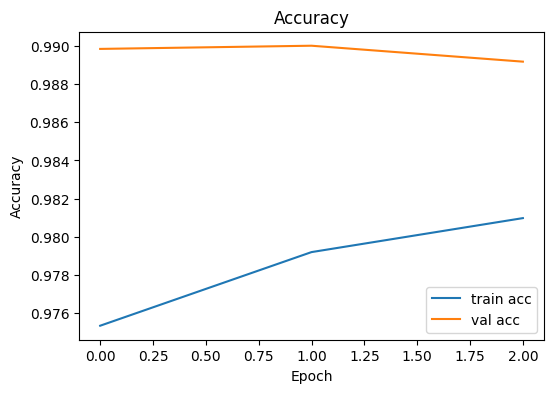

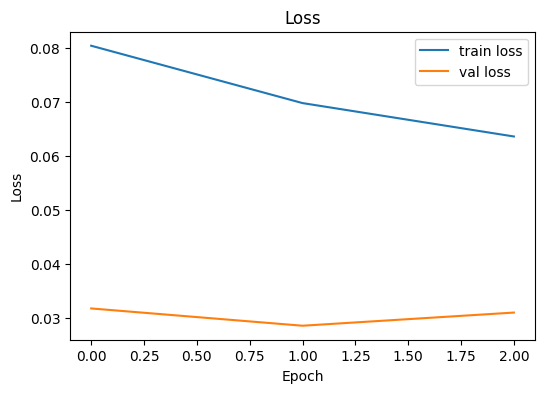

In [21]:
# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')
plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
plt.show()


              precision    recall  f1-score   support

           0     0.9990    0.9898    0.9944       980
           1     0.9956    0.9938    0.9947      1135
           2     0.9866    0.9952    0.9908      1032
           3     0.9960    0.9941    0.9950      1010
           4     0.9839    0.9980    0.9909       982
           5     0.9769    0.9978    0.9872       892
           6     0.9926    0.9843    0.9885       958
           7     0.9893    0.9903    0.9898      1028
           8     0.9959    0.9918    0.9938       974
           9     0.9980    0.9802    0.9890      1009

    accuracy                         0.9915     10000
   macro avg     0.9914    0.9915    0.9914     10000
weighted avg     0.9916    0.9915    0.9915     10000



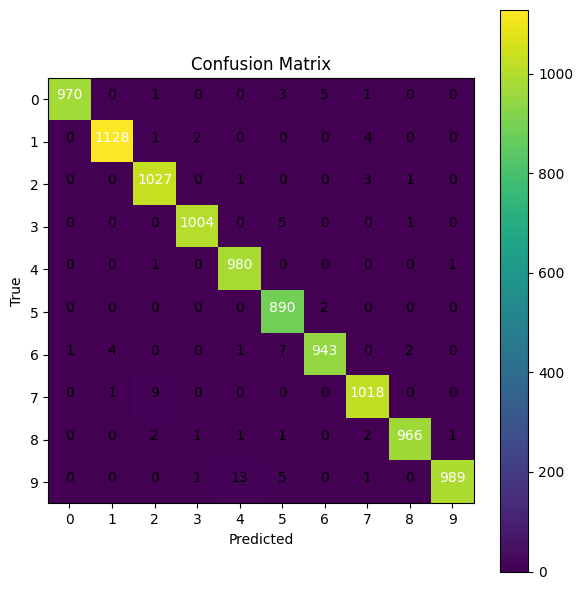

In [22]:
# Predictions (class indices)
probs = model.predict(X_test, batch_size=512, verbose=0)
y_pred = probs.argmax(axis=1)

print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks); plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted'); plt.ylabel('True')

# annotate counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


Per-class AUC: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(0.9999), 9: np.float64(1.0)}
Macro AUC: 1.0


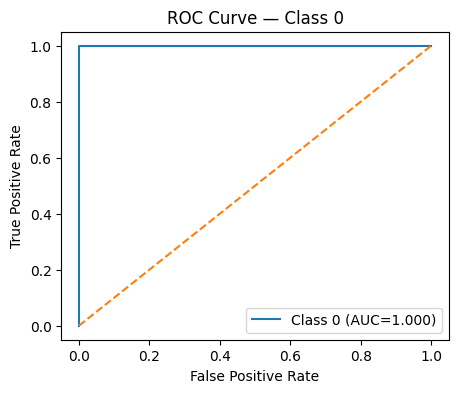

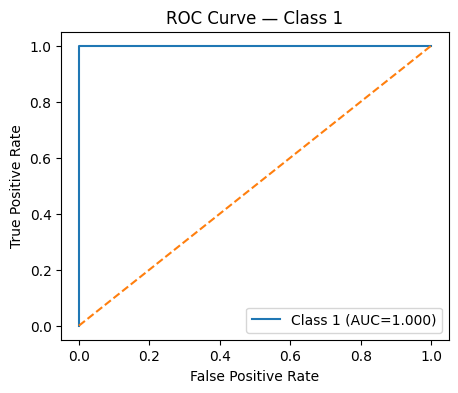

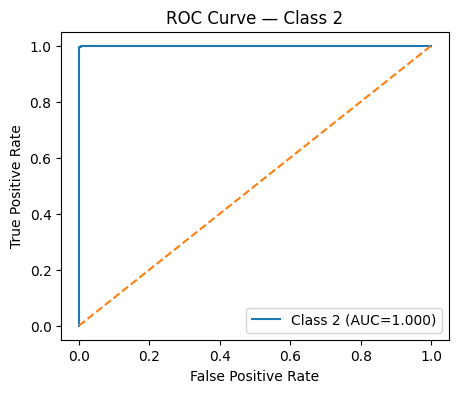

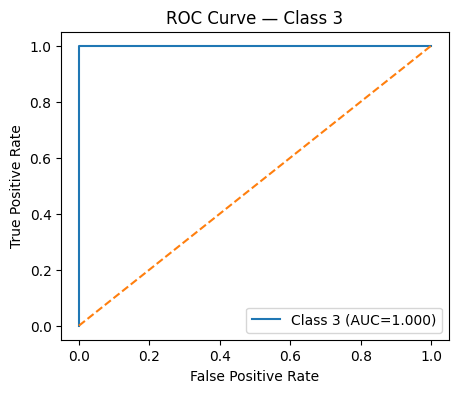

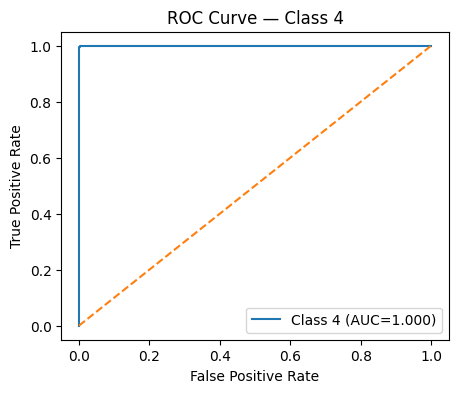

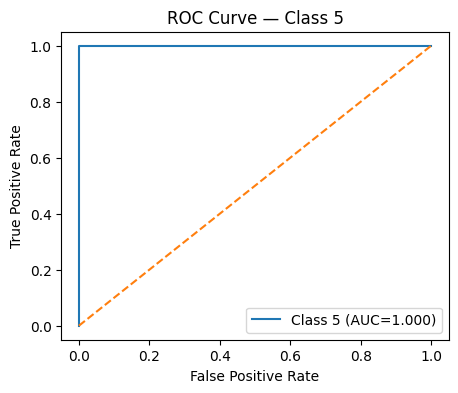

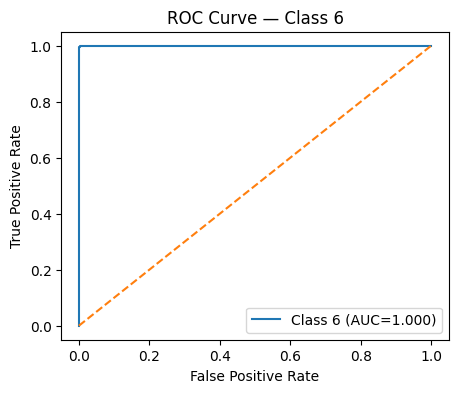

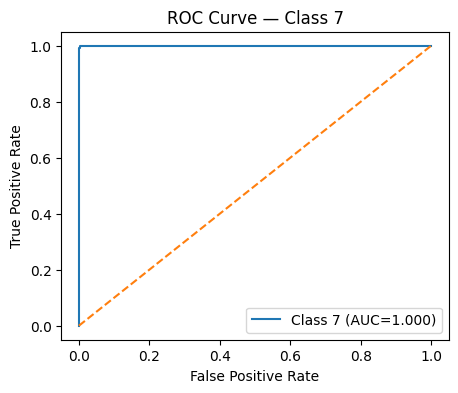

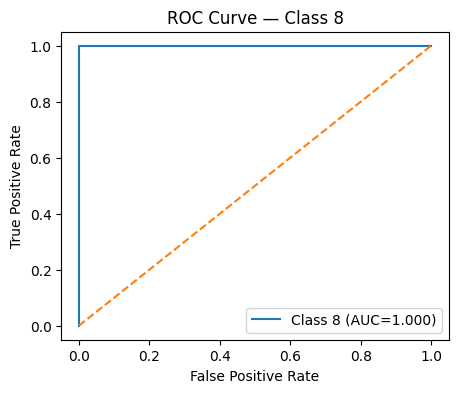

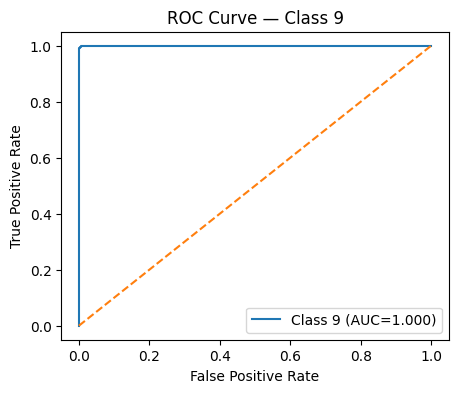

In [23]:
# One-vs-rest ROC AUC
fpr, tpr, roc_auc = {}, {}, {}
for c in range(num_classes):
    fpr[c], tpr[c], _ = roc_curve(y_test_cat[:, c], probs[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

# Macro-average AUC
macro_auc = np.mean(list(roc_auc.values()))
print("Per-class AUC:", {k: round(v,4) for k,v in roc_auc.items()})
print("Macro AUC:", round(macro_auc, 4))

# Plot per-class ROC curves
for c in range(num_classes):
    plt.figure(figsize=(5,4))
    plt.plot(fpr[c], tpr[c], label=f'Class {c} (AUC={roc_auc[c]:.3f})')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve — Class {c}')
    plt.legend()
    plt.show()


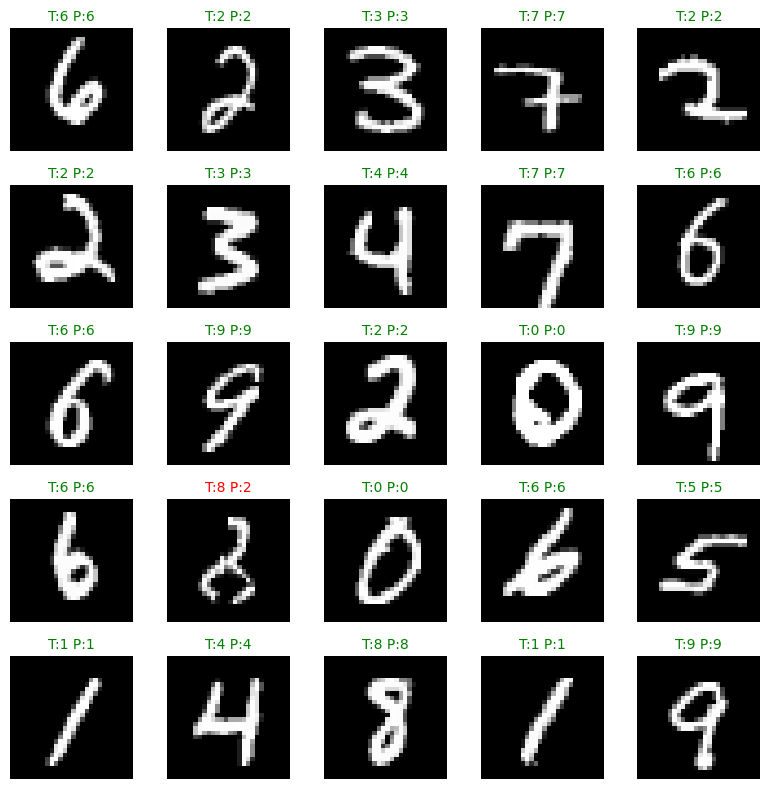

In [24]:
# Show 25 random test examples with prediction vs truth
idxs = np.random.choice(len(X_test), 25, replace=False)
plt.figure(figsize=(8,8))
for i, idx in enumerate(idxs, 1):
    img = X_test[idx].squeeze()
    true_lbl = y_test[idx]
    pred_lbl = y_pred[idx]
    plt.subplot(5,5,i)
    plt.imshow(img, cmap='gray')
    title = f"T:{true_lbl} P:{pred_lbl}"
    color = 'green' if true_lbl == pred_lbl else 'red'
    plt.title(title, color=color, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [25]:
FINAL_PATH = os.path.join(DATA_DIR, 'mnist_final_model.h5')
model.save(FINAL_PATH)
print("Saved:", FINAL_PATH)


Saved: /content/drive/MyDrive/Colab Notebooks/MNIST/mnist_final_model.h5
